 # **AI Machine Learning & Analitics Final Project**
[poner todos los nombres]

**Chosen topic**
Image classification – Recognizing natural scenes

*Building a classification system that recognizes when pictures include different 
elements of a city or nature based on previously labelled images.*

### **Background information & analisis**

For this project, we are going to develop a multiclass classification model, which implies classifying images in a series of possible categories. In multiclass classification, the objective is ot assign a unique class to every image from a predefined pool of existing classes. In this case: "buildings", "forest", "glacier", "mountain", "sea" and "street". This type of problems involving image recognition require a robust model capable of learning and differentiating between distinctive characteristics of each class.

As a first approach to developing our model, we will explore **transfer learning**. Instead of training a model from scratch, transfer learning will help us take advantage of already-existing models that werre trained on large datasets. This will allow us to include complex feature extraction to our model already learnt and adapt them to our dataset through fine-tuning. 

Some of the pretrained models to consider that we could find inlcude:

1. **VGG16/VGG19**: Characterised by their simple structute of 3x3 convolutional layers, efective in hierarchical feature extraction. Nonetheless, we found they can be take up a lot of memory (memory intensive) and can be prone to overfitting. **Link**: https://keras.io/api/applications/vgg/#vgg16-function

2. **ResNet (ResNet50 or ResNet101)**: Its architecture uses residual connexions allowing for a more efficient travelling of gradients in deep networks. It is ideal to capture specific details, such as textures in both nature and urban images, although it can be computational expensive. Total of 177 layers consisting of 5 stages (conv1 to conv5). Given the small size of the dataset, probably wise to freeze all layers until conv4 (included) for basic and mid-level feature extraction and let only layers in conv5 trainable (higher-level features) **Link**: https://keras.io/api/applications/resnet/#resnet50-function

3. **InceptionV3**: Introduces a module structure, using multiple fitler sizes in parallel which makes it a good candidate for capturing details in different scales. Good fit for images that vary in size and resolution, so probably not the best model for our case. Its complex architecture makes it computationally expensive. **Link**: https://keras.io/api/applications/inceptionv3/#inceptionv3-function

4. **EfficientNet**: Consists of 237 layers including ocnvolutional, batch normalisation, activation and pooling layers. Uses a scaled compound to optimise the size and computational efficiency. Adaptable to small and deeper networks, offers a high precision without demanding a lot of resources. **Link**: https://keras.io/api/applications/efficientnet/#efficientnetb0-function

5. **MobileNet**: This model uses convolutional layers that are separable in depth, making it highly efficient in mobile or low-latency envirionments. While it is less precise in capturing complext features, it is ideal for fast and low-resource applications. **Link**: https://keras.io/api/applications/mobilenet/#mobilenet-function


In this project, we will start by experimenting with **VGG16**, **ResNet** and **EfficientNet-B0**, being efective in capturing complext details and features and relatively eficient in resources (expect for ResNet which can be computationally expensive)

### **Code**

In [121]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [122]:
# Function to load labelled data from the source folders 
def load_images(data_dir):
    labels = []
    images = []
    classes = sorted(os.listdir(data_dir))  # Get the folders/classes (labels)

    # Loop through all folders
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        print('Loading class %s' %class_name)
        
        if os.path.isdir(class_folder):
            # Loop through each image file within the class folder
            for img_name in os.listdir(class_folder)[0:1000]:
                img_path = os.path.join(class_folder, img_name)

                try:
                    # Load the image, resize it, and convert to a numpy array
                    img = Image.open(img_path)
                    img = img.resize((64,64)) # Resize in case there are images of different sizes and channels
                    img_array = np.array(img)

                    # Add the image to the list and its corresponding label (class index)
                    images.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, classes

In [123]:
# Actually load the data from the folders
data_dir_train = '../data/seg_train'
data_dir_test = '../data/seg_test'

x_train, y_train, train_classes = load_images(data_dir_train)
x_test, y_test, test_classes = load_images(data_dir_test)

print(f"\nLoaded trian_images: {x_train.shape}")
print(f"Loaded train_labels: {y_train.shape}")
print(f"train_Classes: {train_classes}")

print(f"\nLoaded test_images: {x_test.shape}")
print(f"Loaded test_labels: {y_test.shape}")
print(f"test_Classes: {test_classes}")

Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street
Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street

Loaded trian_images: (6000, 64, 64, 3)
Loaded train_labels: (6000,)
train_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Loaded test_images: (3000, 64, 64, 3)
Loaded test_labels: (3000,)
test_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [124]:
# Process the image data and labels


# Validation split of training data:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# Normalization
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0


# One hot encoding
y_train = to_categorical(y_train, 6) # Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
y_val = to_categorical(y_val, 6)
y_test = to_categorical(y_test, 6)

[0. 0. 0. 1. 0. 0.]


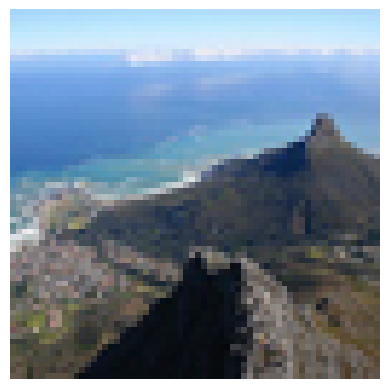

In [108]:
# Check if data is formatted correctly
print(y_train[0]) #Shows the one hot encoding and classification of the first image

plt.imshow(x_train[0])
plt.axis('off')
plt.show()

### **Transfer Leanrning: Implementing Pre-trained Models**

In [125]:
# Imports
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

#### **ResNet50**


In [126]:
# Defining Model-Building function for keras tuner

def build_model_ResNet50(hp):
    # Load the ResNet50 base model
    base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    
  # Freeze all layers up to and including conv4 (up to layer 143)
    for layer in base_model_ResNet50.layers[:144]: # lower trainable layerss
        layer.trainable = False

    x = base_model_ResNet50.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)     # 50% dropout layer
    
    # Tune the number of units in the dense layer
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = Dense(units, activation='relu')(x)
    
    # Output layer
    x = Dense(6, activation='softmax')(x)
    
    model = Model(inputs=base_model_ResNet50.input, outputs=x)
    
    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [127]:
# Initialise Bayesian optimisation tuner

tuner = kt.BayesianOptimization(
    build_model_ResNet50,
    objective='val_accuracy',
    max_trials=10,  # Number of different hyperparameter combinations to try
    directory='my_dir',
    project_name='resnet50_tuning'
)


In [128]:
# Data augmentation transformations

# Given the relatively small size of our dataset, we'll implement different
# data augmentation techniques (rotation, zoom-in, etc) to expand the data
# and prevent overfitting. 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [129]:
# Run Hyperparameter search (with data augmentation on the train set)

tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=5,
             validation_data=(x_val, y_val))


Trial 10 Complete [00h 03m 38s]
val_accuracy: 0.5241666436195374

Best val_accuracy So Far: 0.6191666722297668
Total elapsed time: 00h 35m 16s


In [130]:
# Get the best model from Bayesian Search

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_ResNet50 = tuner.hypermodel.build(best_hps)

print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")


Optimal number of units: 256
Optimal learning rate: 0.0001


In [131]:
# Quick view of the resulting model architecture
model_ResNet50.summary(); 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 14,977,286 (57.13 MB)

 Non-trainable params: 9,136,512 (34.85 MB)

In [132]:
# Training the model using data augmentation (with early stopping):

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_ResNet50.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(x_val, y_val), 
                    callbacks=early_stopping)

Epoch 1/10


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 249ms/step - accuracy: 0.3338 - loss: 1.6799 - val_accuracy: 0.3800 - val_loss: 1.7110
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - accuracy: 0.4923 - loss: 1.2989 - val_accuracy: 0.4350 - val_loss: 1.4395
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.5006 - loss: 1.2711 - val_accuracy: 0.5258 - val_loss: 1.1623
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - accuracy: 0.5230 - loss: 1.2096 - val_accuracy: 0.5767 - val_loss: 1.0891
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 37s 249ms/step - accuracy: 0.5299 - loss: 1.2172 - val_accuracy: 0.6167 - val_loss: 1.0282
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.5304 - loss: 1.1845 - val_accuracy: 0.5917 - val_loss: 1.0380
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 297ms/step - accuracy: 0.5542 - loss: 1.1652 - val_accuracy: 0.6333 - val_loss: 0.9844
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.5699 - loss: 1.1174 - val

In [147]:
# Saving model Weights inside "Weights" folder

import os 

# Define the directory and weights file
weights_path = "Weights/best_model_resnet50.weights.h5"

# Ensure the directory exists
os.makedirs(os.path.dirname(weights_path), exist_ok=True)

# Save the best model's weights
model_ResNet50.save_weights(weights_path)

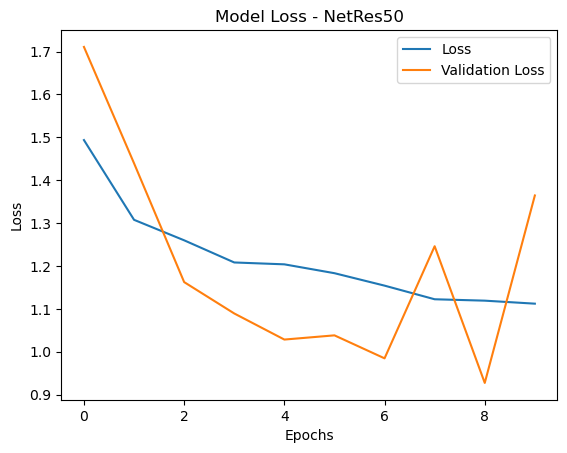

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.7251 - loss: 0.8482
Test accuracy: 0.64


In [134]:
# Evaluate the model

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - NetRes50")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = model_ResNet50.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**: 

The test accuracy of 0.7251 is not bad but also indicates that the model is not generalising very well. The training loss steadily decreases but the validation loss decreases initially but then starts to spike up and down at around epoch 5-6 and eventually increase indicating **overfitting**. We could experiment with lower learning rates (<0.0001) but the validation trends and accuracy suggest limited space for improvement using ResNet50 due to overfitting. ResNet50 appears to be too complex for out dataset. Hence, we decide to move on with VGG16 and EfficientNet-B0


**Next Steps**: try lighter models like VGG16, EfficientNet or MobileNet.

#### **VGG16**

In [94]:
# Import
from tensorflow.keras.applications import VGG16

In [135]:
# Define the model-building function for Bayesian Optimization

def build_model_VGG16(hp):
    # Load the VGG16 base model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    # Freeze a few first layers
    for layer in base_model.layers[:15]:
        layer.trainable = False

    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    # Tune the number of units in the dense layer
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = Dense(units, activation='relu')(x)
    
    # Output layer
    x = Dense(6, activation='softmax')(x)
    
    # Define the complete model
    model = Model(inputs=base_model.input, outputs=x)
    
    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [136]:
# Initialize the Bayesian optimisation tuner

tuner = kt.BayesianOptimization(
    build_model_VGG16,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='vgg16_tuner',
    project_name='vgg16_tuning'
)


In [1]:
# Hyperparameter search (Using Data Augmentation on the train set - previously defined)

tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=5,
             validation_data=(x_val, y_val))


NameError: name 'tuner' is not defined

In [ ]:
# Get the best model from bayesian optimization

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model_VGG16 = tuner.hypermodel.build(best_hps)


In [140]:
# Training without early stopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training with data augmentation in traininn data
history = model_VGG16.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=50, validation_data=(x_val, y_val), callbacks=early_stopping)

Epoch 1/50


/Users/juanbabeyhaut/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 378ms/step - accuracy: 0.4912 - loss: 1.2966 - val_accuracy: 0.8275 - val_loss: 0.4917
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 59s 392ms/step - accuracy: 0.7351 - loss: 0.7008 - val_accuracy: 0.8333 - val_loss: 0.4605
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 60s 400ms/step - accuracy: 0.7954 - loss: 0.6031 - val_accuracy: 0.8483 - val_loss: 0.4448
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 471ms/step - accuracy: 0.8156 - loss: 0.5078 - val_accuracy: 0.8242 - val_loss: 0.4616
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 88s 585ms/step - accuracy: 0.8170 - loss: 0.4909 - val_accuracy: 0.8433 - val_loss: 0.4367
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 84s 557ms/step - accuracy: 0.8324 - loss: 0.4674 - val_accuracy: 0.8700 - val_loss: 0.3741
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 86s 574ms/step - accuracy: 0.8492 - loss: 0.4224 - val_accuracy: 0.8567 - val_loss: 0.4161
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 591ms/step - accuracy: 0.8584 - loss: 0.4081 - val

In [148]:
# Saving model weights inside "Weights" folder

import os 

# Define the directory and weights file
weights_path = "Weights/best_model_vgg16.weights.h5"

# Ensure the directory exists
os.makedirs(os.path.dirname(weights_path), exist_ok=True)

# Save the best model's weights
model_VGG16.save_weights(weights_path)

In [144]:
# Quick view of the model architecture
model_VGG16.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,072,852 (110.90 MB)

 Trainable params: 7,145,862 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,291,726 (54.52 MB)

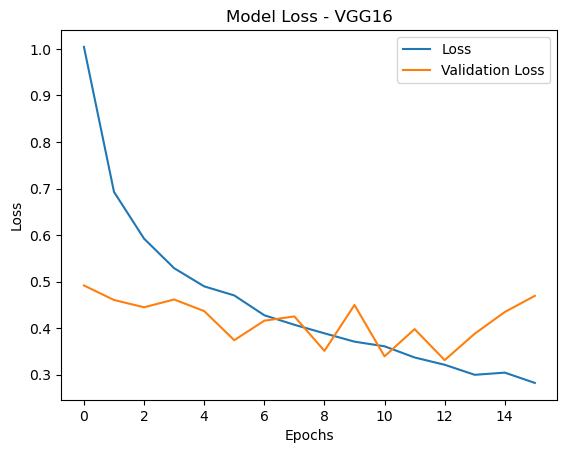

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.8540 - loss: 0.3871
Test accuracy: 0.87


In [146]:
# Evaluating the model

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - VGG16")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = model_VGG16.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

**Interpretation**:  

The high test accuracy of 0.85 indicates that the model generalises relatively well. The training loss steadily decreases while the validation loss decreases subtly initially but then starts to spike up and down at around epoch 5-6 (and eventually increases indicating potential **overfitting**). VGG16 appears to be a sufficiently good model to have as a base.


**Next Steps**: try EfficientNet or MobileNet. And begin constructing our own model to see if we can surpass the 0.85 accuracy achieved by VGG16

#### **EfficientNet**

In [90]:
from tensorflow.keras.applications import EfficientNetB0

In [91]:
def build_model_EfficientNet(hp):
    # Load the EfficientNetB0 base model with pre-trained weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    
    # Freeze all except for the last 30 layers
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    # Add custom layers on top of EfficientNet
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Tune the number of units in the dense layer
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    x = Dense(units, activation='relu')(x)
    
    # Tune the dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(x)
    
    # Output layer
    output = Dense(6, activation='softmax')(x)
    
    # Define the complete model
    model = Model(inputs=base_model.input, outputs=output)
    
    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [92]:
# Initialise bayesiand optimisation search (calling it "efficientnet_tuner")

tuner = kt.BayesianOptimization(
    build_model_EfficientNet,
    objective='val_accuracy',
    max_trials=10,
    directory='efficientnet_tuner',
    project_name='efficientnet_tuning'
)


In [93]:
# Hyperparameter search (Using Data Augmentation on the train set - previously defined)

tuner.search(datagen.flow(x_train, y_train, batch_size=32),
             epochs=5,
             validation_data=(x_val, y_val))


Trial 10 Complete [00h 00m 56s]
val_accuracy: 0.17000000178813934

Best val_accuracy So Far: 0.1850000023841858
Total elapsed time: 00h 08m 47s


In [ ]:
# Get the best model from bayesian optimisation

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model_EfficientNet = tuner.hypermodel.build(best_hps)


In [ ]:
# Quick view of the model architecture
model_EfficientNet.summary()

In [ ]:
# Training the model using data augmentation (with early stopping defined in ResNet section):

# Train the model with data augmentation
history = model_EfficientNet.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=10,
                                 validation_data=(x_val, y_val),
                                 callbacks=[early_stopping])

In [ ]:
# Evaluating the model

# JUANBA

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss - EfficientNet")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss, test_accuracy = model_VGG16.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")